<a href="https://colab.research.google.com/github/Lampent/IRFL-website/blob/main/Downloading_OpenImages_Custom_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
cd /content/gdrive/My Drive

/content/gdrive/My Drive


In [4]:
!mkdir OpenImages

In [5]:
cd OpenImages

/content/gdrive/My Drive/OpenImages


In [6]:
!pwd

/content/gdrive/My Drive/OpenImages


In [7]:

# Download required meta-files
!wget https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv

!wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

!wget https://storage.googleapis.com/openimages/2018_04/validation/validation-annotations-bbox.csv

!wget https://storage.googleapis.com/openimages/2018_04/test/test-annotations-bbox.csv

--2025-11-10 10:27:11--  https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11255 (11K) [text/csv]
Saving to: ‘class-descriptions-boxable.csv’

class-descriptions- 100%[===================>]  10.99K  --.-KB/s    in 0.008s  

2025-11-10 10:27:12 (1.37 MB/s) - ‘class-descriptions-boxable.csv’ saved [11255/11255]

--2025-11-10 10:27:12--  https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1194033454 (1.1G) [

In [119]:
from PIL import Image
import requests
from io import BytesIO

def get_openimage(image_name: str, mode: str = "train") -> Image.Image:
    """
    Downloads an image from the OpenImages dataset and returns it as a PIL Image.

    Args:
        image_name (str): The image ID or name (without extension), e.g., "000123456789abcdef".
        mode (str): Dataset split - one of "train", "validation", or "test". Default = "train".

    Returns:
        PIL.Image.Image: The loaded image.
    """
    url = f"https://open-images-dataset.s3.amazonaws.com/{mode}/{image_name}"
    resp = requests.get(url, stream=True)
    resp.raise_for_status()
    return Image.open(BytesIO(resp.content)).convert("RGB")


In [95]:
# !pip install awscli

In [26]:
import argparse
import csv
import subprocess
import os
from tqdm import tqdm
import multiprocessing
from multiprocessing import Pool as thread_pool
with open('./class-descriptions-boxable.csv', mode='r') as infile:
    reader = csv.reader(infile)
    dict_list = {rows[1]:rows[0] for rows in reader} # key - object name,  value - object code pairs

In [20]:
import pandas as pd
train = pd.read_csv('./train-annotations-bbox.csv')

In [167]:
selected_df = train[:10000].copy()

In [168]:
code_to_name_dict = {v: k for k, v in dict_list.items()}

In [169]:
selected_df['LabelName'] = train['LabelName'].apply(lambda item: code_to_name_dict[item])

In [170]:
import re
from tqdm import tqdm
import pandas as pd

# human-related keywords
keywords = [
    "person","man","woman","women","child","kid","adult","elder",
    "mom","sister","brother","baby","children","people","pepole","dead", "singer", "face", "nose", "hand"
]
pattern = r'\b(?:' + '|'.join(map(re.escape, keywords)) + r')\b'

# 1️⃣ filter out human-related classes
non_human_df = selected_df[~selected_df["LabelName"].str.contains(pattern, case=False, na=False)]

# 2️⃣ count occurrences of each label per image
counts = (
    non_human_df.groupby(["LabelName", "ImageID"])
    .size()
    .reset_index(name="count")
)

# 3️⃣ create mapping with progress bar
class_map_non_human = {}
labels = counts["LabelName"].unique()

for label in tqdm(labels, desc="Building class map", ncols=90):
    group = counts[counts["LabelName"] == label]
    label_dict = (
        group.groupby("count")["ImageID"]
        .apply(list)
        .to_dict()
    )
    class_map_non_human[label] = label_dict

# import pprint
# sample_preview = {k: list(v.items())[:2] for k, v in list(class_map_non_human.items())[:5]}
# pprint.pprint(sample_preview)


Building class map: 100%|██████████████████████████████| 275/275 [00:00<00:00, 562.51it/s]


In [171]:
# # 4️⃣ if you just want {class: {count: [ids]}} printed nicely:
# import pprint
# pprint.pprint(class_map_non_human['Pillow'])

In [172]:
# !pip install word2number

In [173]:
import re
from word2number import w2n
import pandas as pd
import inflect

p = inflect.engine()

def extract_fields(entry):
    caption = entry.get("caption", "").lower().strip()
    pred_name = entry.get("pred_image_name", "")
    words = re.findall(r"\b[a-z]+\b|\d+", caption)  # simple tokenization (remove punctuation)

    # 1️⃣ edit_type
    edit_type = "add" if "add" in words else "remove" if "remove" in words else None

    # 2️⃣ count: detect either digit or written number
    count = None
    m = re.search(r"\b(\d+)\b", caption)
    if m:
        count = int(m.group(1))
    else:
        try:
            idx = words.index(edit_type) + 1 if edit_type in words else 0
            count = w2n.word_to_num(" ".join(words[idx:idx + 3]))
        except Exception:
            pass

    # 3️⃣ object = all words from the 3rd onward (singularized)
    obj = None
    if len(words) > 2:
        obj_tokens = words[2:]
        obj = " ".join(obj_tokens).strip()
        if obj:
            # singularize last word
            parts = obj.split()
            last = parts[-1]
            singular = p.singular_noun(last)
            if singular:
                parts[-1] = singular
            obj = " ".join(parts)

    # 4️⃣ original_count from filename like "-chip-5.0.png"
    m2 = re.search(r"-[A-Za-z_]+-(\d+(?:\.\d+)?)", pred_name)
    original_count = int(float(m2.group(1))) if m2 else None

    return {
        "edit_type": edit_type,
        "count": count,
        "object": obj,
        "original_count": original_count
    }

def extract_testset_metadata(testset):
    return pd.DataFrame({k: extract_fields(v) for k, v in testset.items()}).T

import json
# Example use:
with open('./test_mapping_instruction.json', 'r') as f:
    testset = json.load(f)

df = extract_testset_metadata(testset)

In [174]:
import pandas as pd

# df columns: image_key, object, edit_type, count, original_count

pairs_map = (
    df.dropna(subset=["object", "original_count", "count", "edit_type"])
      .assign(
          original_count=lambda d: d["original_count"].astype(int),
          requested_count=lambda d: d["count"].astype(int),
      )
      .groupby(["object", "edit_type"])[["original_count", "count"]]
      .apply(lambda g: list(map(tuple, g[["original_count", "count"]].to_numpy())))
      .unstack(fill_value=[])
      .to_dict()
)


In [175]:
import random
import pandas as pd
import inflect
from typing import Dict, Any, List

p = inflect.engine()
random.seed(1337)

def plural(obj: str, n: int) -> str:
    return p.plural(obj, n) if n != 1 else obj

def build_testset_using_classmap_counts(
    df: pd.DataFrame,
    class_map_non_human: Dict[str, Dict[int, List[str]]],
) -> Dict[str, Dict[str, Any]]:
    """
    Build testset using real OpenImages IDs from class_map_non_human[object][original_count].
    If no exact (object, original_count) match is found, pick a random allowed object that has valid counts.
    """
    d = df.copy()
    d["object"] = d["object"].astype(str).str.strip().str.lower()
    d["edit_type"] = d["edit_type"].astype(str).str.strip().str.lower()
    d["count"] = pd.to_numeric(d["count"], errors="coerce")
    d["original_count"] = pd.to_numeric(d["original_count"], errors="coerce")

    # Normalize map keys
    cmap = {k.strip().lower(): {int(k2): v for k2, v in d2.items()} for k, d2 in class_map_non_human.items()}
    allowed_objects = list(cmap.keys())

    testset = {}

    for _, row in d.iterrows():
        obj = row["object"]
        etype = row["edit_type"]
        req = int(row["count"]) if pd.notna(row["count"]) else 1
        if pd.isna(row["original_count"]):
            continue
        orig = int(row["original_count"])

        ids_for_obj = cmap.get(obj, {}).get(orig)

        # Fallback: pick a random object with at least one valid count entry
        if not ids_for_obj:
            alt_obj = random.choice([o for o, counts in cmap.items() if counts])
            alt_counts = list(cmap[alt_obj].keys())
            alt_orig = random.choice(alt_counts)
            ids_for_obj = cmap[alt_obj][alt_orig]
            obj, orig = alt_obj, alt_orig
            print(f"No exact match for ({row['object']}, {row['original_count']}), using ({obj}, {orig})")

        ref_id = random.choice(ids_for_obj)
        verb = "Add" if etype == "add" else "Remove"
        caption = f"{verb} {req} {plural(obj, req)}."
        obj_for_name = obj.replace(" ", "_")
        pred_image_name = f"{caption}-{obj_for_name}-{orig}.jpg"

        testset[ref_id] = {
            "caption": caption,
            "ref_image_path": ref_id,          # real OpenImages ID (no extension)
            "pred_image_name": pred_image_name,
            "edit_type": etype,
            "requested_count": req,
            "original_count": orig,
            "object": obj,
        }

    return testset


# ---------------------------- Usage ----------------------------
new_testset = build_testset_using_classmap_counts(df, class_map_non_human)
# assert len(new_testset) == len(df)
new_testset

No exact match for (chip, 5.0), using (wine, 8)
No exact match for (bottle, 9.0), using (dragonfly, 1)
No exact match for (caterpillar, 8.0), using (penguin, 1)
No exact match for (potato, 7.0), using (footwear, 12)
No exact match for (cushion, 3.0), using (sparrow, 3)
No exact match for (balloon, 2.0), using (turtle, 1)
No exact match for (stamp, 4.0), using (shelf, 1)
No exact match for (gem, 6.0), using (paddle, 1)
No exact match for (knife, 6.0), using (hiking equipment, 1)
No exact match for (kite, 10.0), using (swimming pool, 1)
No exact match for (refrigerator, 4.0), using (bread, 1)
No exact match for (pillow, 10.0), using (shorts, 3)
No exact match for (samosa, 8.0), using (balloon, 6)
No exact match for (folder, 8.0), using (flowerpot, 1)
No exact match for (lamppost, 7.0), using (flowerpot, 1)
No exact match for (boat, 7.0), using (baked goods, 2)
No exact match for (tire, 9.0), using (grapefruit, 1)
No exact match for (shampoo, 11.0), using (furniture, 7)
No exact match for

{'0000608cc97a2b17': {'caption': 'Remove 10 wines.',
  'ref_image_path': '0000608cc97a2b17',
  'pred_image_name': 'Remove 10 wines.-wine-8.jpg',
  'edit_type': 'remove',
  'requested_count': 10,
  'original_count': 8,
  'object': 'wine'},
 '00022a23d0e4add5': {'caption': 'Remove 10 dragonflies.',
  'ref_image_path': '00022a23d0e4add5',
  'pred_image_name': 'Remove 10 dragonflies.-dragonfly-1.jpg',
  'edit_type': 'remove',
  'requested_count': 10,
  'original_count': 1,
  'object': 'dragonfly'},
 '00018690d4ceff1c': {'caption': 'Remove 1 penguin.',
  'ref_image_path': '00018690d4ceff1c',
  'pred_image_name': 'Remove 1 penguin.-penguin-1.jpg',
  'edit_type': 'remove',
  'requested_count': 1,
  'original_count': 1,
  'object': 'penguin'},
 '00002b368e91b947': {'caption': 'Remove 10 footwears.',
  'ref_image_path': '00002b368e91b947',
  'pred_image_name': 'Remove 10 footwears.-footwear-12.jpg',
  'edit_type': 'remove',
  'requested_count': 10,
  'original_count': 12,
  'object': 'footwear'

In [182]:
def get_openimage(image_id: str, mode: str = "train") -> Image.Image:
    """Download an OpenImages image and return it as a PIL Image."""
    url = f"https://open-images-dataset.s3.amazonaws.com/{mode}/{image_id}.jpg"
    os.makedirs(mode, exist_ok=True)
    save_path = os.path.join(mode, f"{image_id}.jpg")

    r = requests.get(url)
    r.raise_for_status()
    with open(save_path, "wb") as f:
        f.write(r.content)

    return Image.open(BytesIO(r.content)).convert("RGB")

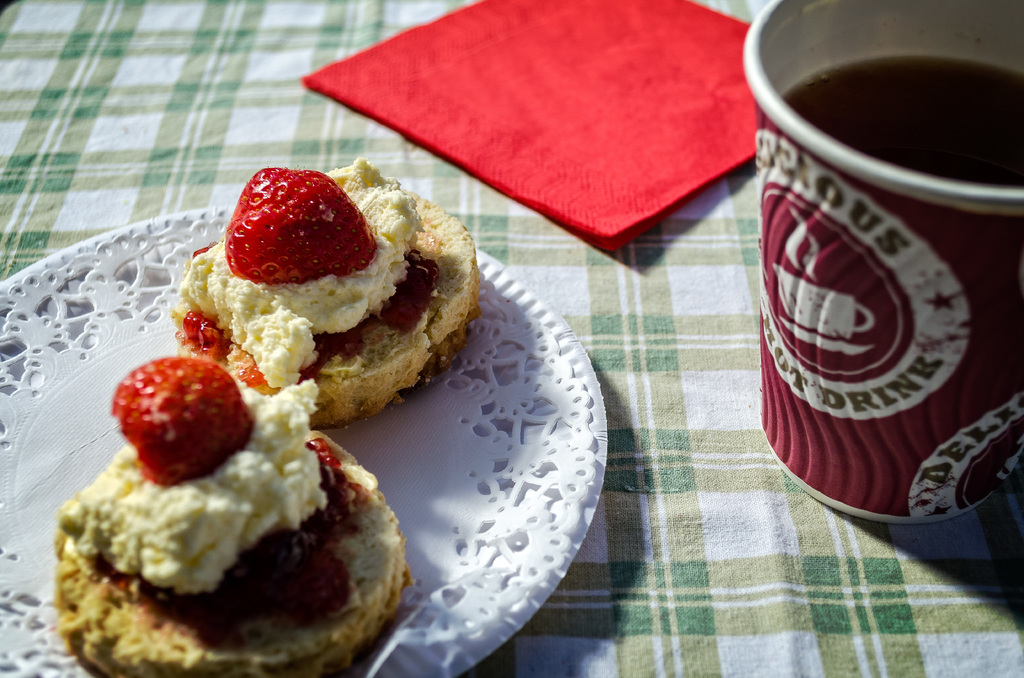

In [186]:
get_openimage('00030b70a3abfcea')